## imports

In [1]:
import os

import tensorflow as tf
from tensorflow.keras.layers import Conv3D, Activation, MaxPool3D, Conv3DTranspose, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import numpy as np

import glob

import nibabel as nib
from nibabel.testing import data_path

from IPython.display import clear_output

## Diagram for reference

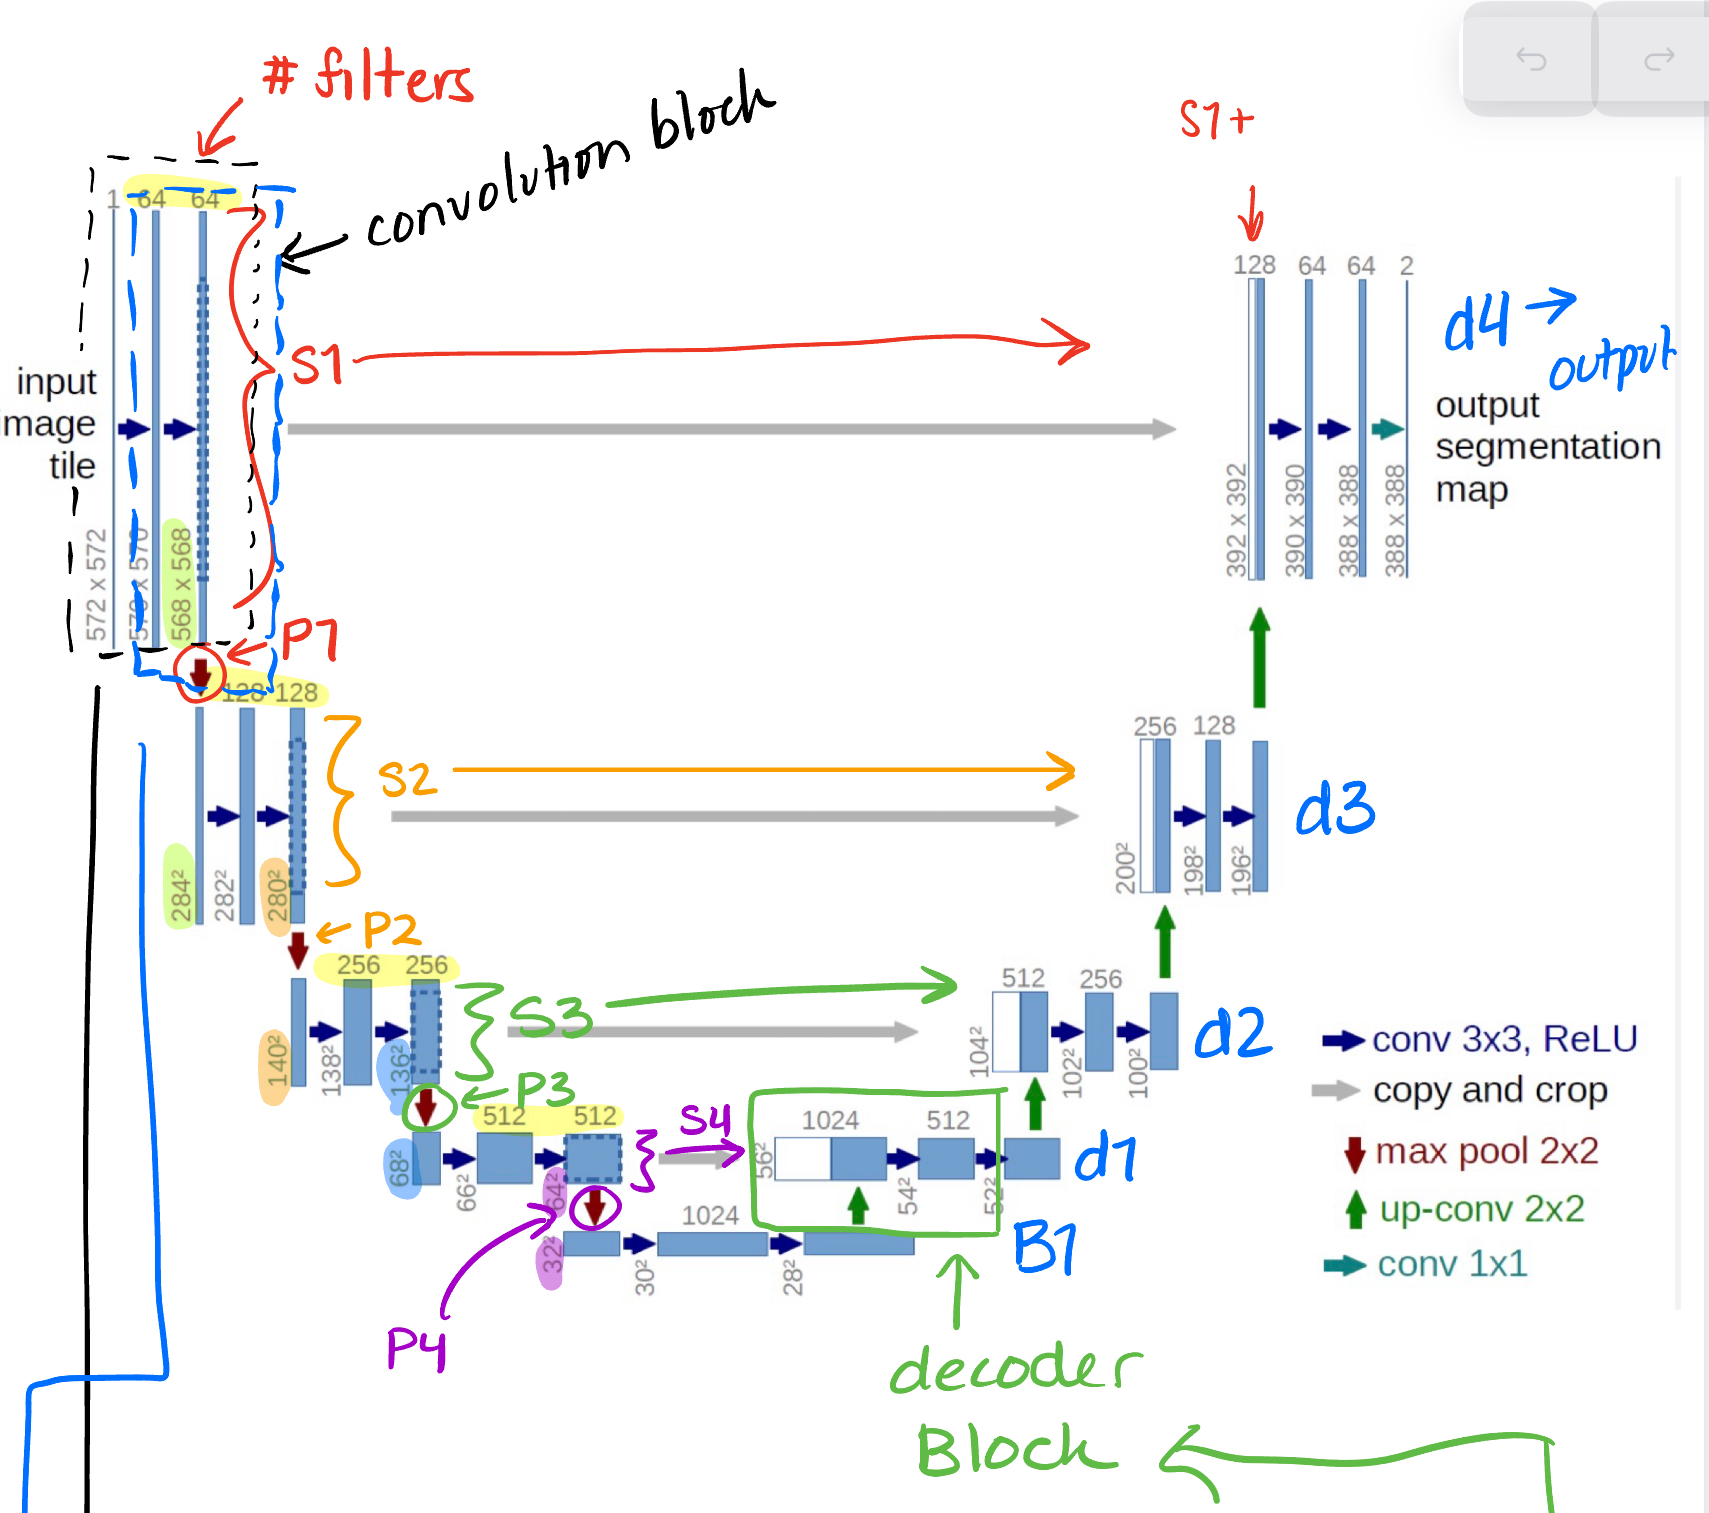

In [6]:
from IPython.display import Image, display
display(Image(filename='2d_unet_ex.jpg'))

## Loading data


In [3]:
def load_data(path, patch_size=(64,64,64)):
    """
    patch_size = tuple containing patch size of images for training

    T1- native format 
    T1CE - contrast enhanced image of T1
    T2 - weighted
    T2 Fluid Attenuated Inversion Recovery FLAIR volumes
    """
    t1ce_all = []
    t1_all = []
    t2_all = []
    flair_all = []
    mask_all = []

    # search through MRI files and assign sample names to image files by labeling. 
    for mri_folder in os.listdir(path):
        file_path = os.path.join(path, mri_folder)

        #extracting t1ce for all 369 patients
        t1ce_files = glob.glob(os.path.join(file_path, "*_t1ce.nii")) #returns a list
        for t1ce_file in t1ce_files:
            t1ce_img = nib.load(t1ce_file)
            t1ce_img_data = t1ce_img.get_fdata()
            t1ce_all.append(t1ce_img_data)
        
        #extracting t2-weighted for all 369 patients
        t2_weighted_files = glob.glob(os.path.join(file_path, "*_t2.nii"))
        for t2_weighted_file in t2_weighted_files:
            t2_weighted_img = nib.load(t2_weighted_file)
            t2_weighted_img_data = t2_weighted_img.get_fdata()
            t2_all.append(t2_weighted_img_data)
    
        #extracting t2-flair data for all 369 patients       
        t2_flair_files = glob.glob(os.path.join(file_path, "*_flair.nii")) #returns a list
        for t2_flair_file in t2_flair_files:
            t2_flair_img = nib.load(t2_flair_file)
            t2_flair_img_data = t2_flair_img.get_fdata()
            #height, width, depth = t2_flair_img_data.shape
            #print(f'height = {height}, width = {width}, depth = {depth}')
            flair_all.append(t2_flair_img_data)
            
        #extracting t1 data for all 369 patients
        t1_files = glob.glob(os.path.join(file_path, "*_t1.nii"))
        for t1_file in t1_files:
            t1_img = nib.load(t1_file)
            t1_data = t1_img.get_fdata()
            t1_all.append(t1_data)
        
        mask_files = glob.glob(os.path.join(file_path, "*_seg.nii"))
        for mask_file in mask_files:
            mask_file_img = nib.load(mask_file)
            mask_file_img_data = mask_file_img.get_fdata()
            mask_all.append(mask_file_img_data)

    return mask_all,t1_all, t1ce_all, t2_all, flair_all

## image dimensions

t1 scan dimensions: height = 240, width = 240, depth = 155

t1ce scan dimensions: height = 240, width = 240, depth = 155

t2 scan dimensions: height = 240, width = 240, depth = 155

flair scan dimensions: 240, width = 240, depth = 155

## testing loading

In [4]:
#path specific to Julian  /Users/dolan/Dropbox/MSSE/277B_ML/277B_final/277B_final/BraTS2020_scans 

mask_data, t1_data, t1ce_data, t2_data, flair_data = load_data('/Users/dolan/Dropbox/MSSE/277B_ML/277B_final/277B_final/BraTS2020_scans')


In [5]:
#all working
print(t1_data[:5])
#print(t1ce_data[:5])
#print(t2_data[:5])
#print(flair_data[:5])
#print(mask_data[:5])

[memmap([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
   

## Display image form each channel

In [4]:
def display_channels(patient_num, slice_num):
    patient_t1 = t1_data[patient_num]
    print("T1:")
    plt.imshow(patient_t1[:,:,slice_num])
    plt.show()

    print('T1CE:')
    patient_t1ce = t1ce_data[patient_num]
    plt.imshow(patient_t1ce[:,:,slice_num])
    plt.show()

    print('T2:')
    patient_t2 = t2_data[patient_num]
    plt.imshow(patient_t2[:,:,slice_num])
    plt.show()


    print("Flair:")
    patient_flair = flair_data[patient_num]
    plt.imshow(patient_flair[:,:,slice_num])
    plt.show()

    print("mask:")
    patient_mask = mask_data[patient_num]
    plt.imshow(patient_mask[:,:,slice_num])
    plt.show()


T1:


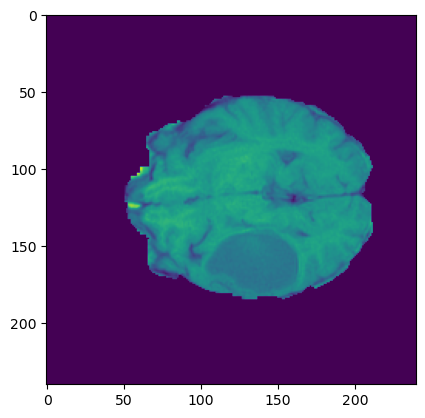

T1CE:


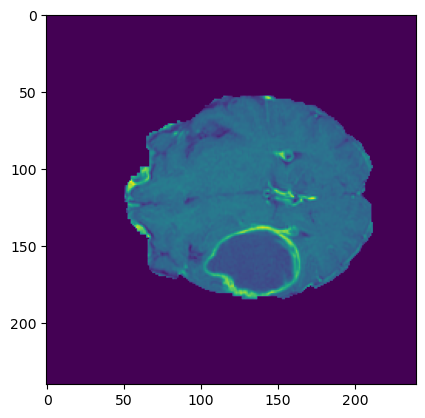

T2:


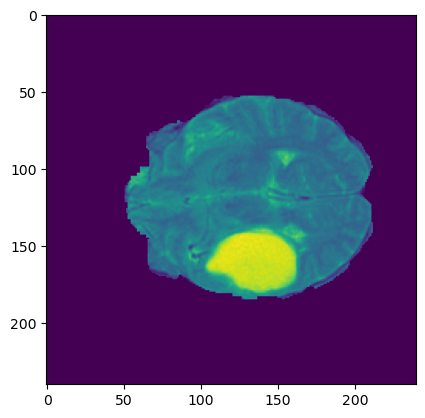

Flair:


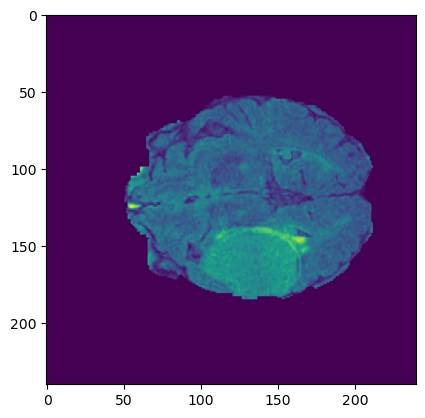

mask:


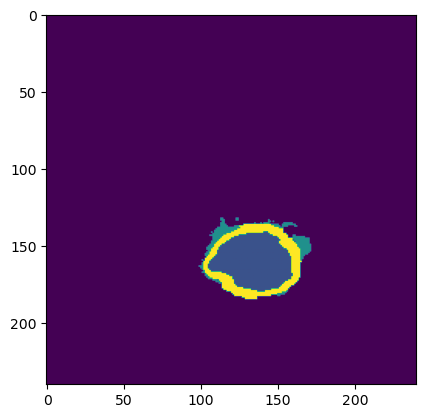

In [5]:
display_channels(56,70)
#patient 56 has a tumor

## Dropping channel T1

T1 channel does not provide additional information that T1CE, T2, and Flair provide, therefore our group chose to not include it.

In [4]:
del t1_data

## Creating Generator

processes data in batches so the kernel does not die.

In [5]:
def generator(big_data, batch_size):
    '''
    Parameters
    ----------
    big_data: list 
    list of images

    batch_size: int
    number of images per batch

    Yields
    -------
    batch: list
    yields the entire original list "big data" but in subsection of size batch_size
    '''
    for i in range(0, len(big_data),batch_size):
        batch = big_data[i:i+batch_size]
        yield batch

## Data Preprocessing

crop to remove black space in scan

scale (mask should NOT be scaled)

combine all channels into one channel

change mask labels

save as numpy arr

split into training and validation

## Cropping Image

must crop to save space and prevent kernel from dying

uncropped all images are 240x240x155

after cropping,
cropped images should be 128x128x128

note one limitation of this project is that we are losing a bit of the image, if a tumor happens to be towards the back of the brain our model may not learn to detect that well because it always cropped out. for the sake of compute, we must sacrifice the model performance. 

In [6]:
t1ce_cropped = []
for batch in generator(t1ce_data,8):
    for image in batch:
        t1ce_cropped.append(image[56:184, 76:204, 20:148])

t2_cropped = []
for batch in generator(t2_data,8):
    for image in batch:
        t2_cropped.append(image[56:184, 76:204, 20:148])

flair_cropped = []
for batch in generator(flair_data,8):
    for image in batch:
        flair_cropped.append(image[56:184, 76:204, 20:148])

mask_cropped = []
for batch in generator(mask_data,8):
    for image in batch:
        mask_cropped.append(image[56:184, 76:204, 20:148])


## Check that cropping worked

In [7]:
def display_channels_cropped(patient_num, slice_num):
    print('T1CE:')
    patient_t1ce = t1ce_cropped[patient_num]
    plt.imshow(patient_t1ce[:,:,slice_num])
    plt.show()

    print('T2:')
    patient_t2 = t2_cropped[patient_num]
    plt.imshow(patient_t2[:,:,slice_num])
    plt.show()

    print("Flair:")
    patient_flair = flair_cropped[patient_num]
    plt.imshow(patient_flair[:,:,slice_num])
    plt.show()

    print("mask:")
    patient_mask = mask_cropped[patient_num]
    plt.imshow(patient_mask[:,:,slice_num])
    plt.show()


T1CE:


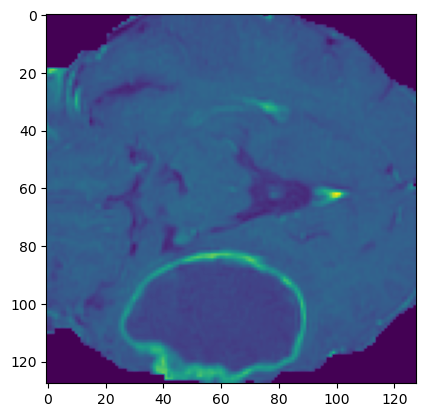

T2:


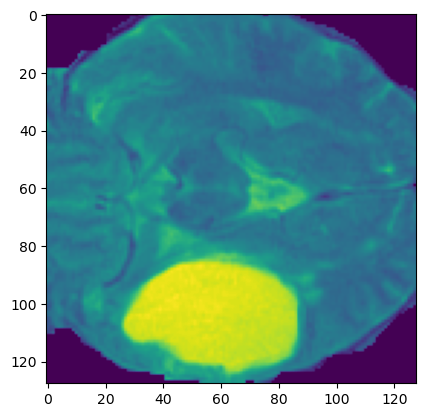

Flair:


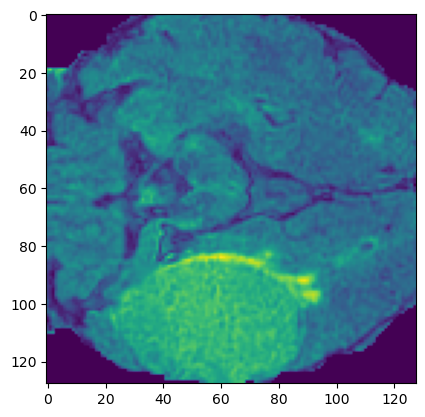

mask:


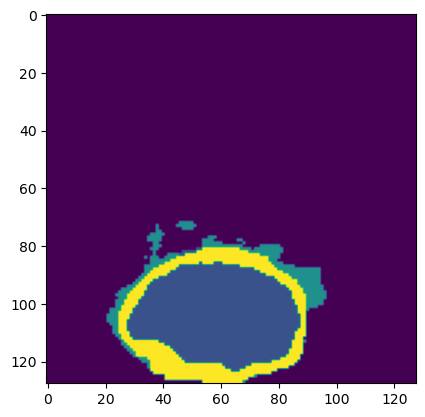

In [8]:
display_channels_cropped(56,45)

## Scaling

must scale in batches to prevent kernel from dying


https://wiki.python.org/moin/Generators

https://blog.finxter.com/5-best-ways-to-split-a-python-list-into-batches/

In [9]:
#Preprocessing 
#scale image with MinMaxScaler()

def scale_images(image_list):
        scaler = MinMaxScaler()
        scaled_images = []
        #go through each image in batch
        for image in image_list:
            #flatten, scale, reshape back
            scaled_image = scaler.fit_transform(image.reshape(-1,image.shape[-1])).reshape(image.shape)
            scaled_images.append(scaled_image)

        return scaled_images #will return several batches, will need a for loop outside this function to capture all data.

In [10]:
t1ce_scaled = []

for batch in generator(t1ce_cropped, batch_size = 4):
    t1ce_scaled.extend(scale_images(batch)) #using extend converts t1ce_data(numpy.memmap) into t1ce_scaled(numpy.ndarray)

In [11]:
t2_scaled = []
for batch in generator(t2_cropped, batch_size = 4):
    t2_scaled.extend(scale_images(batch)) 

In [12]:
flair_scaled = []
for batch in generator(flair_cropped, batch_size = 4):
    flair_scaled.extend(scale_images(batch))

## Check that scaling worked. 

image dimensions should still be 240x240x155
but the min and max value of an image should be zero and one respectively.

In [13]:
print(t1ce_scaled[0].shape)
print(np.min(t1ce_scaled[0]))
print(np.max(t1ce_scaled[0]))

print(type(t1ce_data[0]))
print(type(t1ce_scaled[0]))
print(type(t2_scaled[0]))
print(type(flair_scaled[0]))

(128, 128, 128)
0.0
1.0
<class 'numpy.memmap'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## Exploring Mask

https://www.med.upenn.edu/cbica/brats2020/data.html

Data description from UPenn says...

0 - blank

4 - enhacing tumor

2 - edema

1 - necrotic and non-enchancing tumor

Therefore, in an individual mask there should only be unique values, 0,1,2,4

In [14]:
print(np.unique(mask_cropped[100]))
print(mask_cropped[100].shape)

[0. 1. 2. 4.]
(128, 128, 128)


Our goal is binary tumor segmentation

Must change every value that is greater than 0 into a 1.

0 - not tumor

1 - tumor

In [15]:
#np.array(mask_data)

#change all 4s to 3s
mask_binary = []
for batch in generator(mask_cropped, 4):
    batch = [np.array(mask) for mask in batch] #convert to numpy
    
    for i in range(len(batch)):
        batch[i][batch[i] > 0 ] = 1 #if voxel is greater than 0, set it equal to 1
        mask_binary.append(batch[i])

## Check that we made mask binary while maintaining shape
should be unique values [0,1]
shape (240,240,155)

In [16]:
print(np.unique(mask_binary[100]))
print(mask_binary[100].shape)

[0. 1.]
(128, 128, 128)


## Combine 3 Channels into 1

want the model to have as much helpful information as possible, so combining all three channels into one

combine t1ce_scaled, t2_scaled, and flair_scaled into one tensor

https://www.reddit.com/r/computervision/comments/1c6ow4z/how_to_merge_2_colour_channels_into_a_single/?rdt=62794

In [17]:
print(len(t1ce_scaled))
print(len(t2_data))
print(len(flair_data))

369
369
369


## Create generator to combine

In [18]:
def combine_generator(t1ce, t2, flair, batch_size):
    combined_list = []
    for i in range(0, len(t1ce), batch_size ): #note that t1ce,t2, and flair are all the same length
        t1ce_batch = t1ce[i: i + batch_size]
        t2_batch = t2[i: i + batch_size]
        flair_batch = flair[i : i + batch_size]
        
        combined_batch = [np.stack([t1ce_img, t2_img, flair_img], axis = 3) for t1ce_img, t2_img, flair_img in zip (t1ce_batch, t2_batch, flair_batch)]

        yield combined_batch

## Combine into a t1ce, t2, and flair into single tensor

In [19]:
combined = []
for combined_batch in combine_generator(t1ce_scaled, t2_scaled, flair_scaled, 2):
    combined.extend(combined_batch) #use extend to add each image in the batch as individual element

## check that combine worked

want it to be shape 128,128,128,3

In [20]:
print(combined[0].shape)

(128, 128, 128, 3)


## save combined and mask

In [ ]:
np.save("combined_tensors.npy", combined)
np.save("binary_masks.npy", mask_binary)

## Load in augmented X and Y

In [2]:
x_aug = np.load('x_aug.npy')

In [3]:
y_aug = np.load('y_aug.npy')

## load combined and mask to avoid redoing preprocessing

In [4]:
x = np.load('combined_tensors.npy')
print(len(x))

y = np.load('binary_mask.npy')
print(len(y))

369
369


## combine augmented images with original images

x combined length should be 783
y combined length should be 783

In [5]:
x_combined = np.concatenate((x_aug, x), axis = 0)
del x
del x_aug

In [6]:
print(y_aug.shape)
print(y.shape)

(369, 128, 128, 128, 1)
(369, 128, 128, 128)


In [7]:
#shape reshape y_aug to 369, 128, 128, 128

y_aug = np.squeeze(y_aug, axis=-1)

In [8]:
print(y_aug.shape)

(369, 128, 128, 128)


In [9]:
y_combined = np.concatenate((y_aug, y), axis = 0)
del y_aug
del y

In [10]:
print(len(x_combined))
print(len(y_combined))

738
738


## shuffle the augmented and original images

In [11]:
index = np.arange(738)

np.random.shuffle(index)

In [12]:
x_shuffled = x_combined[index]

In [13]:
del x_combined

In [14]:
y_shuffled = y_combined[index]

In [15]:
del y_combined

## train, validation, and test split

In [ ]:
'''
CANNOT DO IT THIS WAY CAUSES KERNEL TO DIE bc train_test_split makes copies which takes up too  much memory
x_train, x_temp, y_train, y_temp = train_test_split(x_shuffled,y_shuffled, train_size = .76 )

del x_shuffled
del y_shuffled
'''
train_size = int(len(x_shuffled) * 0.76)
x_train, x_temp = x_shuffled[:train_size], x_shuffled[train_size:]
y_train, y_temp = y_shuffled[:train_size], y_shuffled[train_size:]

del x_shuffled
del y_shuffled


In [17]:

#split temp to get validation validation and train

x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size = 33)

In [18]:
print(len(x_train)+len(x_val)+len(x_test))

print(len(y_train)+len(y_val)+len(y_test))

print("x_train len:",len(x_train))
print("x_test len:" ,len(x_test))
print("x_val len:", len(x_val))



738
738
x_train len: 560
x_test len: 33
x_val len: 145


## Save x_train, x_val, x_test, y_train, y_val, and y_test as numpy arrays

will be able to use this data consistently and saves compute time

In [19]:
#save x
np.save('x_train_shuffled.npy',x_train)
np.save('x_val_shuffled.npy', x_val)
np.save('x_test_shuffled.npy', x_test)

#save y
np.save('y_train_shuffled.npy',y_train)
np.save('y_val_shuffled.npy', y_val)
np.save('y_test_shuffled.npy',y_test)


## Load in saved numpy arrays

x and y should be arrays now

In [ ]:
#load x
x_train = np.load('x_train_shuffled.npy')
x_val = np.load('x_val_shuffled.npy')
x_test = np.load('x_test_shuffled.npy')

#load y
y_train = np.load('y_train_shuffled.npy')
y_val = np.load('y_val_shuffled.npy')
y_test = np.load('y_test_shuffled.npy')

In [56]:
print(len(x_train)+len(x_val)+len(x_test))

print(len(y_train)+len(y_val)+len(y_test))

369
369


## Components of 3D u-net

In [20]:
def conv_block(input, n_filters):
    '''
    the input goes through two Conv3D layers, no upsampling or downsampling
    used to get output from encoder side that will be concatenated on the upsampling side of the decoder
    as well as within the downsampling and upsampling functions

    Parameters:
    ----------
    inputs: tensor 
    n_filters: int
    number of filters in convolution layer

    Returns: 
    ---------
    tensor WITHOUT any downsampling or upsampling
    '''
    #convolution layer #1
    x = Conv3D(n_filters, 3, padding = "same")(input)
    ##ADD BATCH NORMALIZATION OR DROP OUT HERE MAYBE??
    x = Activation('relu')(x)

    #convolution layer #2
    x = Conv3D(n_filters, 3, padding = "same")(x)
    ##ADD BATCH NORMALIZATION OR DROPOUT HERE??
    x = Activation('relu')(x)

    return x


def encoder_block(input, n_filters):
    '''
    Returns the resulting tensor after passing through two convolution layers and DOWNSAMPLED
    this output is necessary to descend into lower levels on the encoder side

    Parameters
    ------
    input: tensor
    n_filters: int
    the number of fiilters you want to apply

    Returns
    -------
    x: tensor after only passing through convolution layers
    p: tensor after passing through convolution layers and undergoing maxpooling
    '''
    x = conv_block(input, n_filters)
    p = MaxPool3D((2,2,2))(x)
    return x, p

def decoder_block(input, skip_features, n_filters):
    '''
    upsamples the inputs, concatenates the outputs from the encoder then pass through the convolution filters

    Parameters
    ----------
    input: tensor
    skip_features: tensor from the encoder (that has not been downsampled )
    the output from the encoder block without downsampling
    n_filters: the number of filters

    Returns
    -------
    x: tensor
    returns the tensor which results from upsampling the inputs, contatenating the input with the outputs from the encoder,
    then passing through two convolution layers

    '''
    x = Conv3DTranspose(n_filters, (2,2,2), strides = 2, padding = 'same')(input) #upsample
    x = Concatenate()([x, skip_features]) #concatenate the features from encoder and decoder
    x = conv_block(x, n_filters) #2 convolution filters
    return x

## 3d u-net

In [21]:
def build_3dunet(input_shape):

    '''
    creates a u net model which has four layers and one bridge. 
    layer filters are (16,32,64,128,256)
    activation is relu
    downsampling is 2,2,2
    upsampling is 2,2,2
    
    '''
    inputs = Input(input_shape)
    
    ### encoder side of u-net ###
    #s(skip connection) is will be concatenated later to the decoder side
    #p (pooling)is output after maxpooling, used to descend to lower layers
    s1, p1 = encoder_block(inputs, 16) #layer 1
    s2, p2 = encoder_block(p1, 32) #layer 2
    s3, p3 = encoder_block(p2, 64) #layer 3
    s4, p4 = encoder_block(p3, 128) #layer 4

    ### bridge ###
    b1 = conv_block(p4, 256)

    ### decoder ###
    #d is the output from the decoder block
    d1 = decoder_block(b1, s4, 128)
    d2 = decoder_block(d1, s3, 64)
    d3 = decoder_block(d2, s2, 32)
    d4 = decoder_block(d3, s1, 16)

    outputs = Conv3D(1,1,1, padding = 'same', activation = 'sigmoid')(d4) #use sigmoid as we are doing binary segmentation

    model = Model(inputs, outputs, name= '3DU-net')

    return model



In [22]:
#These functions are taken from tutorial #6

def dice_coef(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)  # Flatten the ground truth mask to a 1D array
    y_pred_flatten = K.flatten(y_pred)  # Flatten the predicted mask to a 1D array

    intersection = K.sum(y_true_flatten * y_pred_flatten)  # Calculate the overlap (intersection) between true and predicted masks
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)  # Sum of all true and predicted pixels (union)
    return (2 * intersection + smooth) / (union + smooth)  # Dice formula with smoothing factor


# function to create dice loss
def dice_loss(y_true, y_pred, smooth=100):
    return -dice_coef(y_true, y_pred, smooth)

# function to create iou coefficient
def iou_coef(y_true, y_pred, smooth=100):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    intersection = K.sum(y_true * y_pred)  # Calculate intersection (overlap between true and predicted masks)
    sum = K.sum(y_true + y_pred)  # Calculate the total sum of true and predicted pixels
    iou = (intersection + smooth) / (sum - intersection + smooth)  # IoU formula with smoothing factor
    return iou

In [23]:
model = build_3dunet((128,128,128,3))

model.compile(Adamax(learning_rate = 0.001), loss = dice_loss, metrics = ['accuracy', iou_coef, dice_coef])

model.summary()

Model: "3DU-net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 128, 128,  │      1,312 │ input_layer[0][0] │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ conv3d[0][0]      │
│ (Activation)        │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 128, 128,  │      6,928 │ activation[0][0]  │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ conv3d_1[0][0]    │
│ (Activation)        │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling3D)      │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 64, 64,    │     13,856 │ max_pooling3d[0]… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ conv3d_2[0][0]    │
│ (Activation)        │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 64, 64,    │     27,680 │ activation_2[0][… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ conv3d_3[0][0]    │
│ (Activation)        │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 32, 32,    │          0 │ activation_3[0][… │
│ (MaxPooling3D)      │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 32, 32,    │     55,360 │ max_pooling3d_1[… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 32, 32,    │          0 │ conv3d_4[0][0]    │
│ (Activation)        │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 32, 32,    │    110,656 │ activation_4[0][… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 32, 32,    │          0 │ conv3d_5[0][0]    │
│ (Activation)        │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_2     │ (None, 16, 16,    │          0 │ activation_5[0][… │
│ (MaxPooling3D)      │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_6 (Conv3D)   │ (None, 16, 16,    │    221,312 │ max_pooling3d_2[

 Total params: 5,645,777 (21.54 MB)

 Trainable params: 5,645,777 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

## Making a generator for x_train and y_train

In [25]:
def train_generator(x,y, batch_size):
    while True:
        for i in range(0,len(x), batch_size):
            x_batch = x[i : i + batch_size].astype('float32')
            y_batch = y[i : i + batch_size].astype('float32')
            y_batch = np.expand_dims(y_batch, axis = -1)
            yield(x_batch,y_batch)

## Training the Model

In [26]:
train_gen = train_generator(x_train, y_train, 8)
valid_gen = train_generator(x_val, y_val, 8)

In [27]:
print(f'x_train length: {len(x_train)}')
print(len(x_train)+len(x_val)+len(x_test))

print(len(y_train)+len(y_val)+len(y_test))


x_train length: 560
738
738


## saving history

In [28]:
#imports to save training history

from keras.callbacks import CSVLogger

# Reference: https://stackoverflow.com/questions/50127527/how-to-save-training-history-on-every-epoch-in-keras

csv_logger = CSVLogger("model2_aug_history_log.csv", append = True)

In [29]:

epochs = 10
batch_size =8
callbacks = [ModelCheckpoint('unet.keras', verbose=0, save_best_only=True)] #save checkpoints

history = model.fit(train_gen,
                    steps_per_epoch=int(len(x_train) // batch_size),  # Convert to integer
                    epochs=epochs,
                    verbose=1,
                    callbacks=[csv_logger],
                    validation_data=valid_gen,
                    validation_steps=int(len(x_val) // batch_size))  # Convert to integer


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 4192s 60s/step - accuracy: 0.4115 - dice_coef: 0.1075 - iou_coef: 0.0574 - loss: -0.1075 - val_accuracy: 0.9275 - val_dice_coef: 0.3587 - val_iou_coef: 0.2250 - val_loss: -0.3587
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 4216s 60s/step - accuracy: 0.9181 - dice_coef: 0.3288 - iou_coef: 0.2037 - loss: -0.3288 - val_accuracy: 0.9346 - val_dice_coef: 0.4379 - val_iou_coef: 0.2877 - val_loss: -0.4379
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 4270s 61s/step - accuracy: 0.9409 - dice_coef: 0.4199 - iou_coef: 0.2718 - loss: -0.4199 - val_accuracy: 0.9472 - val_dice_coef: 0.5173 - val_iou_coef: 0.3596 - val_loss: -0.5076
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 4269s 61s/step - accuracy: 0.9502 - dice_coef: 0.4793 - iou_coef: 0.3238 - loss: -0.4793 - val_accuracy: 0.9646 - val_dice_coef: 0.5906 - val_iou_coef: 0.4283 - val_loss: -0.5864
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 4434s 63s/step - accuracy: 0.9567 - dice_coef: 0.5124 - iou_coef: 0.3503 - loss: -0.5124 - val

## Save model after Training

In [30]:
model.save("unet_model2_aug.keras")

import os

file_path = "model2_aug_history_log.csv"
if os.path.exists(file_path):
    print(f"File '{file_path}' exists.")
else:
    print(f"File '{file_path}' does not exist.")


File 'model2_aug_history_log.csv' exists.


## Model Performance Evaluation

plot_training taken from tutorial #6

In [31]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_iou = hist.history['iou_coef']
    tr_dice = hist.history['dice_coef']
    tr_loss = hist.history['loss']

    val_acc = hist.history['val_accuracy']
    val_iou = hist.history['val_iou_coef']
    val_dice = hist.history['val_dice_coef']
    val_loss = hist.history['val_loss']

    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    index_iou = np.argmax(val_iou)
    iou_highest = val_iou[index_iou]
    index_dice = np.argmax(val_dice)

    dice_highest = val_dice[index_dice]
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]

    Epochs = [i+1 for i in range(len(tr_acc))]

    acc_label = f'best epoch= {str(index_acc + 1)}'
    iou_label = f'best epoch= {str(index_iou + 1)}'
    dice_label = f'best epoch= {str(index_dice + 1)}'
    loss_label = f'best epoch= {str(index_loss + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 20))
    plt.style.use('fivethirtyeight')

    # Training Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Training IoU
    plt.subplot(2, 2, 2)
    plt.plot(Epochs, tr_iou, 'r', label= 'Training IoU')
    plt.plot(Epochs, val_iou, 'g', label= 'Validation IoU')
    plt.scatter(index_iou + 1 , iou_highest, s= 150, c= 'blue', label= iou_label)
    plt.title('Training and Validation IoU Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    # Training Dice
    plt.subplot(2, 2, 3)
    plt.plot(Epochs, tr_dice, 'r', label= 'Training Dice')
    plt.plot(Epochs, val_dice, 'g', label= 'Validation Dice')
    plt.scatter(index_dice + 1 , dice_highest, s= 150, c= 'blue', label= dice_label)
    plt.title('Training and Validation Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice')
    plt.legend()

    # Training Loss
    plt.subplot(2, 2, 4)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout
  
    plt.savefig("train_history2_aug.png")

    plt.show()

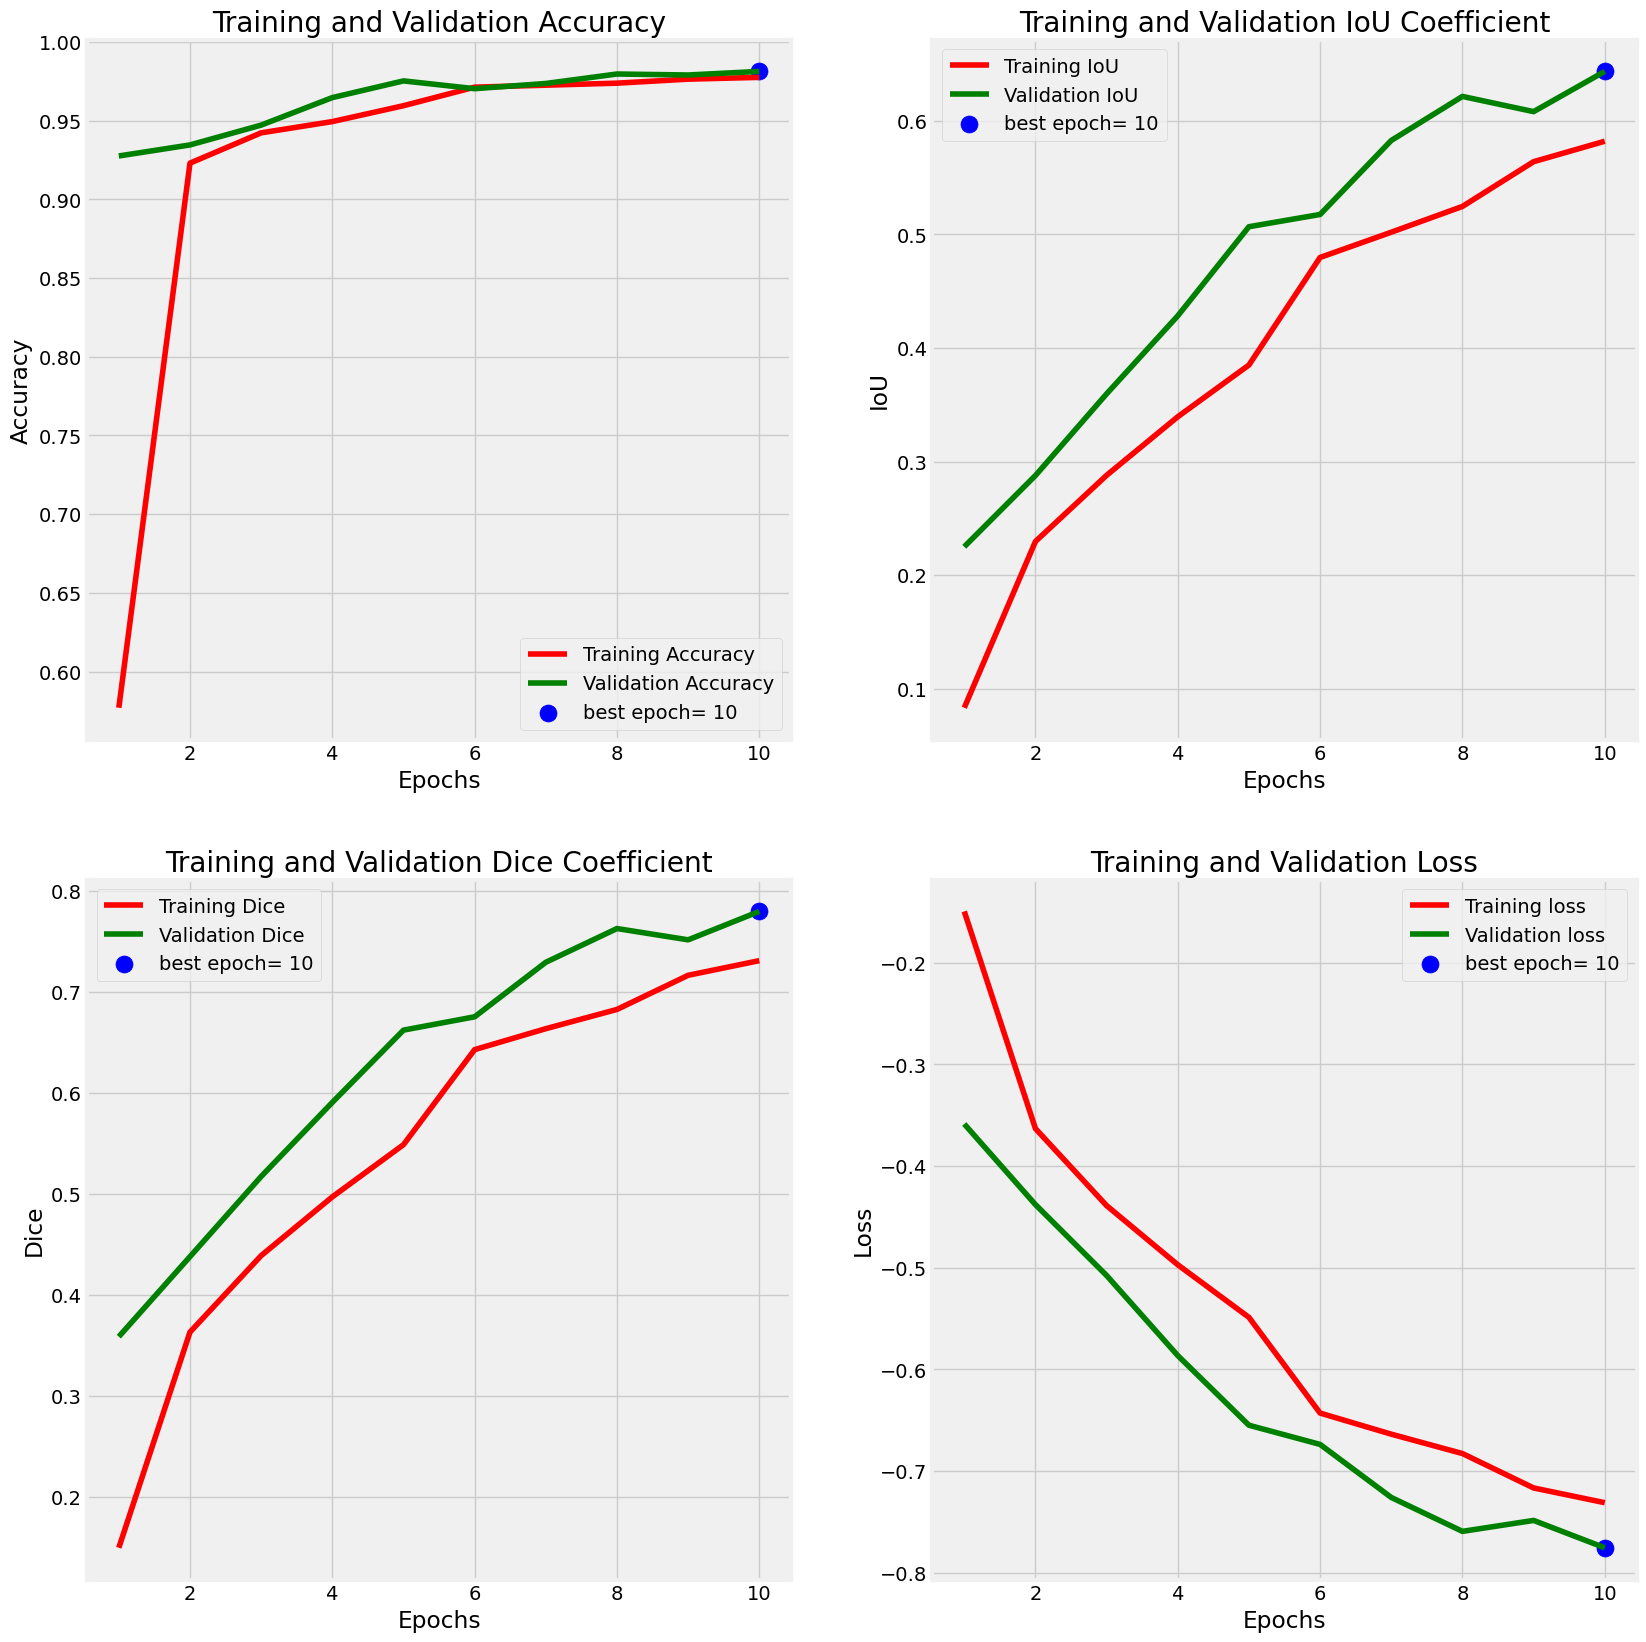

In [32]:
plot_training(history)

## Load model

In [34]:
import os

model_path = '/Users/dolan/Dropbox/MSSE/277B_ML/277B_final/277B_final/unet_model2_aug.keras'
if os.path.exists(model_path):
    print("Model file exists.")
else:
    print("Model file does not exist.")


Model file exists.


In [43]:
from tensorflow.keras.models import load_model


#loaded_model = tf.keras.models.load_model('/Users/dolan/Dropbox/MSSE/277B_ML/277B_final/277B_final/unet_model2_aug.keras', custom_objects = {'dice_loss': dice_loss, 'iou_coef':iou_coef })

## Make Predictions

In [36]:
preds = model.predict(x_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 722ms/step


## Save predictions

In [37]:
np.save('preds_aug.npy',preds)

## Evaluate

In [38]:
#evalute giving shape error
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

#x_test and y_test have different shapes

x_test shape: (33, 128, 128, 128, 3)
y_test shape: (33, 128, 128, 128)


In [39]:
#changing y_test to match, want it to be 33,128,128,128,1
y_test =  np.expand_dims(y_test, axis = -1)

print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_test shape: (33, 128, 128, 128, 3)
y_test shape: (33, 128, 128, 128, 1)


In [40]:
test_loss, test_accuracy, test_dice_coef, test_iou_coef = model.evaluate(x_test,y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 604ms/step - accuracy: 0.9760 - dice_coef: 0.7177 - iou_coef: 0.5597 - loss: -0.7167


## Display the ground truth mask and the predicted mask

In [41]:
def display_predictions(patient_num, slice_num):


    patient_mask = y_test[patient_num]
  
    predicted_mask = preds[patient_num]

    fig, axs = plt.subplots(1,2)

    axs[0].imshow(patient_mask[:,:,slice_num])
    axs[0].set_title('Ground Truth Mask')

    axs[1].imshow(predicted_mask[:,:,slice_num])
    axs[1].set_title('Predicted Mask')

    plt.show()

    print('--------------------------')


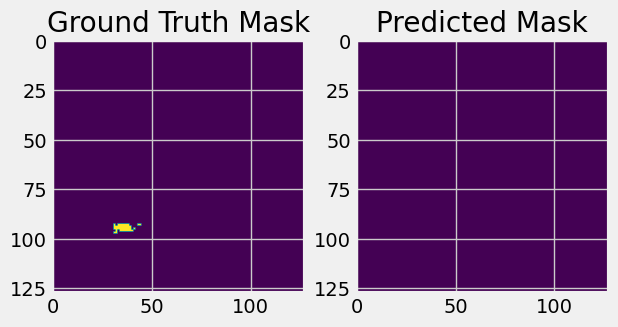

--------------------------


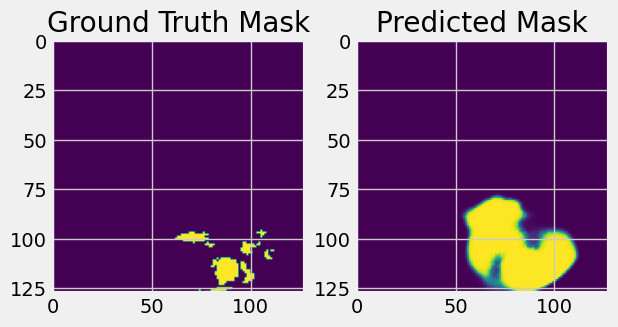

--------------------------


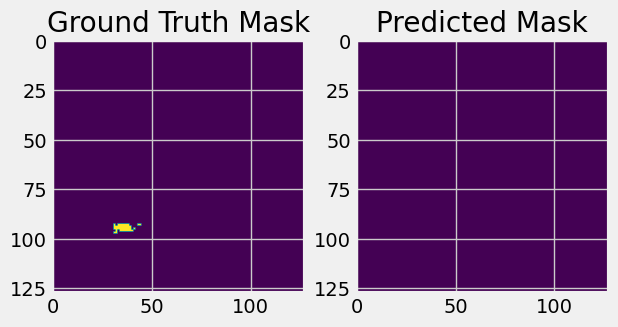

--------------------------


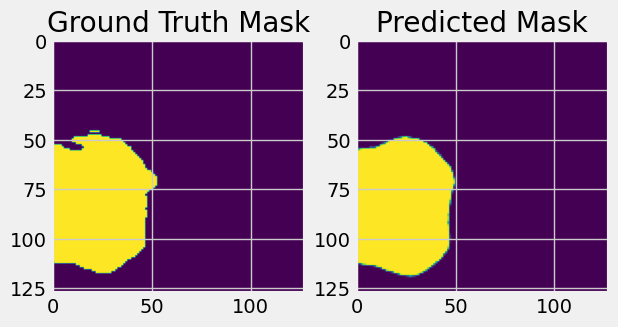

--------------------------


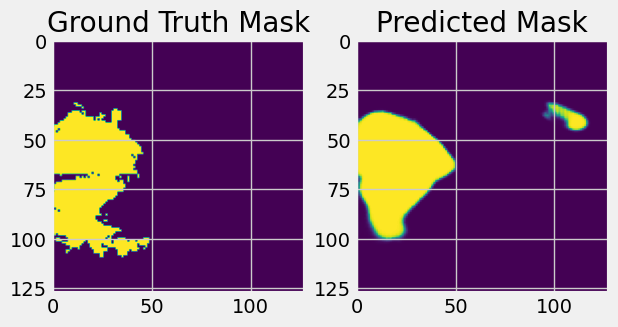

--------------------------


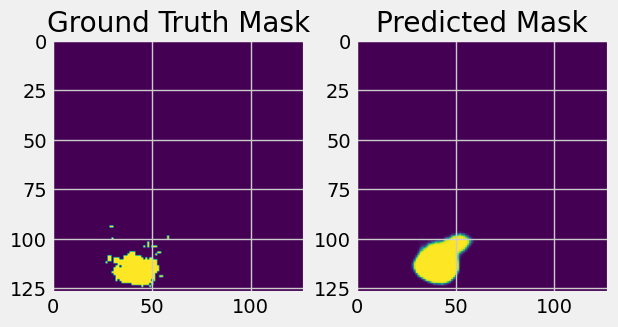

--------------------------


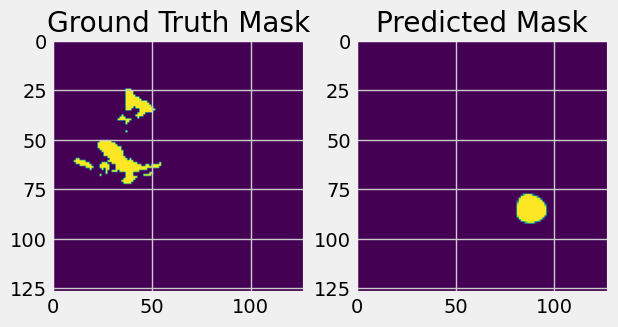

--------------------------


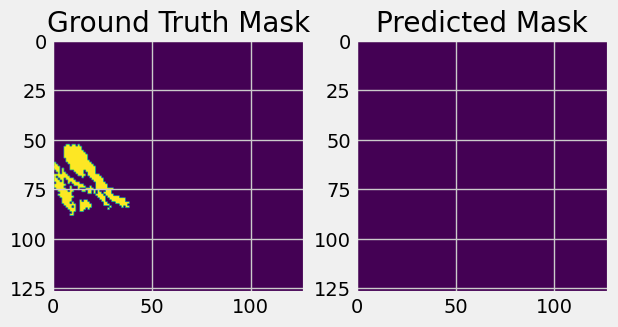

--------------------------


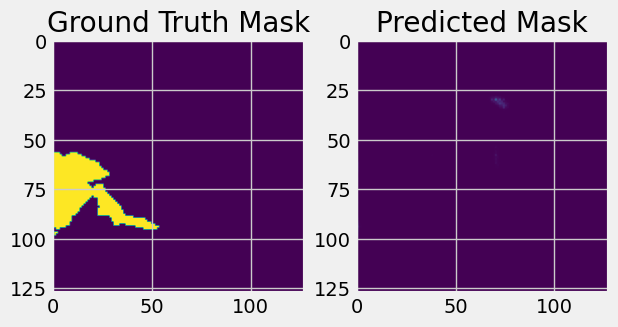

--------------------------


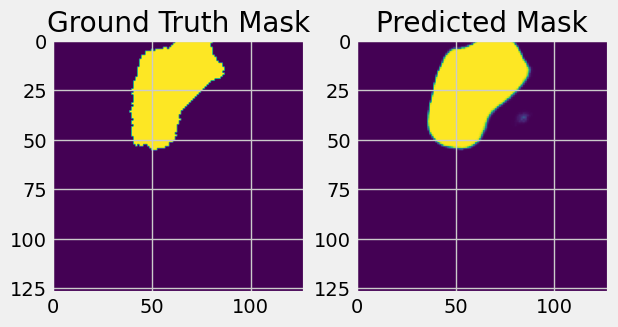

--------------------------


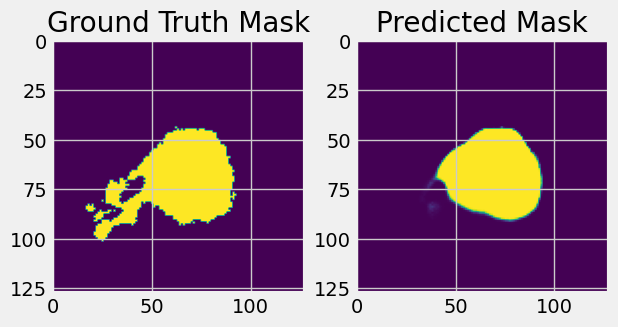

--------------------------


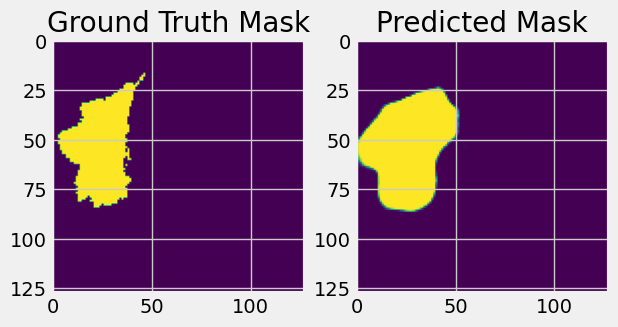

--------------------------


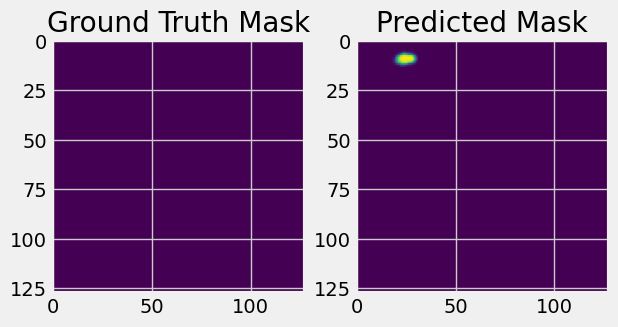

--------------------------


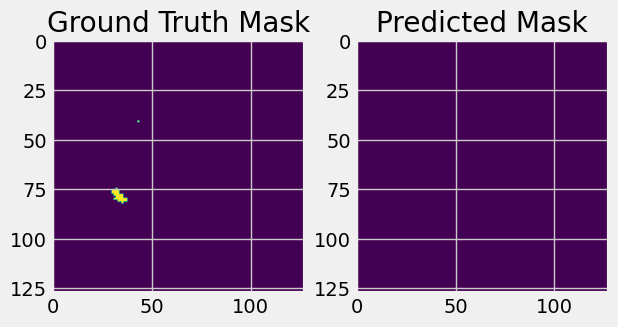

--------------------------


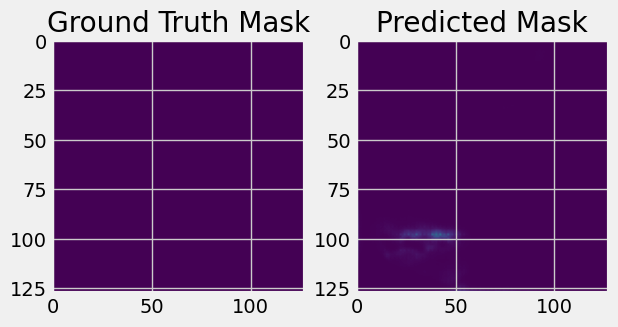

--------------------------


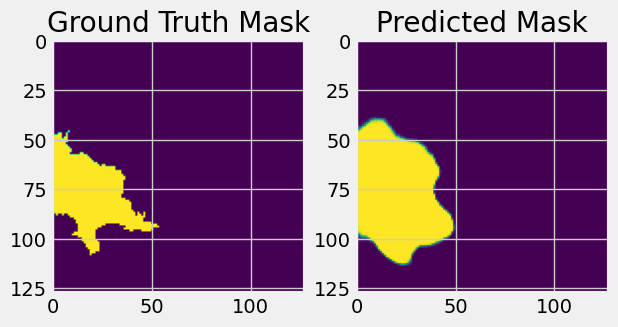

--------------------------


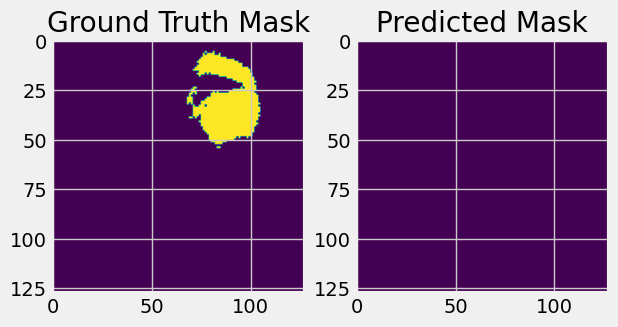

--------------------------


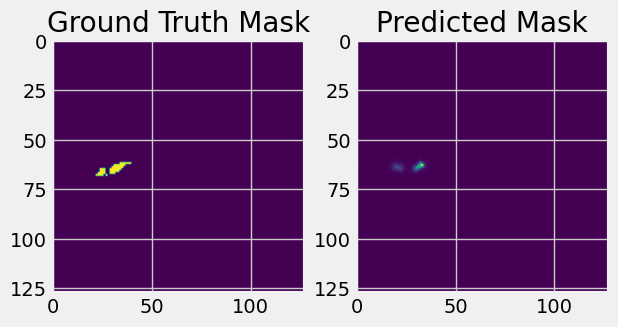

--------------------------


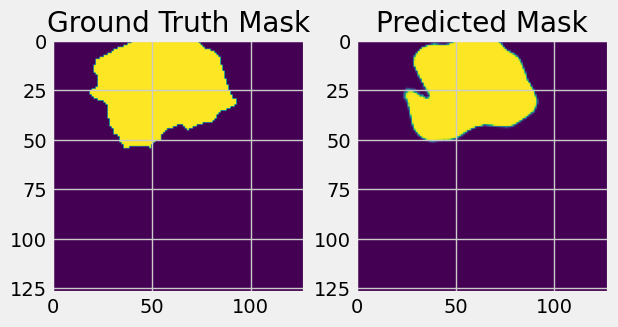

--------------------------


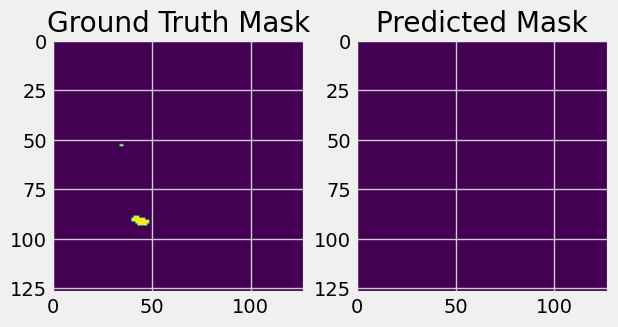

--------------------------


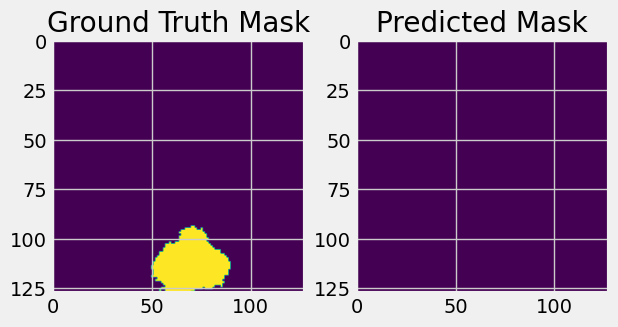

--------------------------


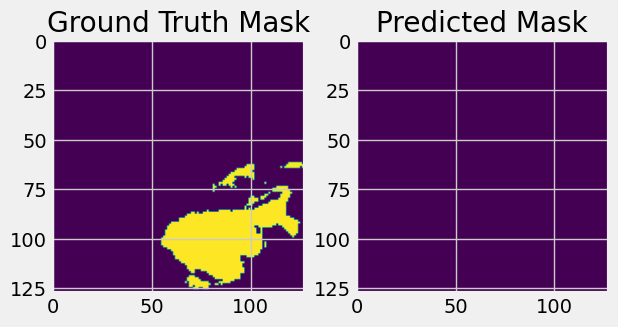

--------------------------


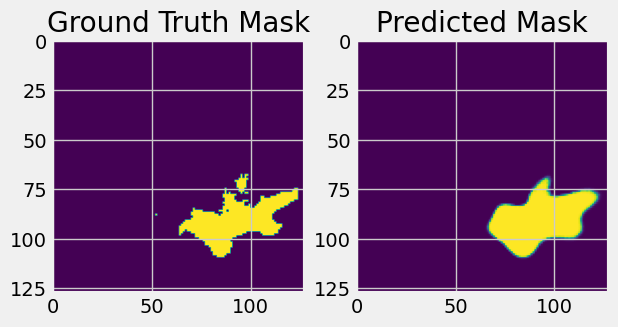

--------------------------


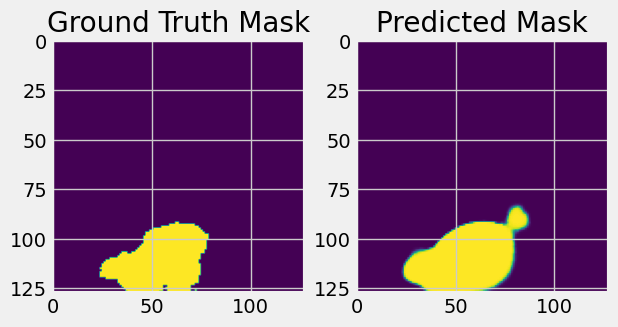

--------------------------


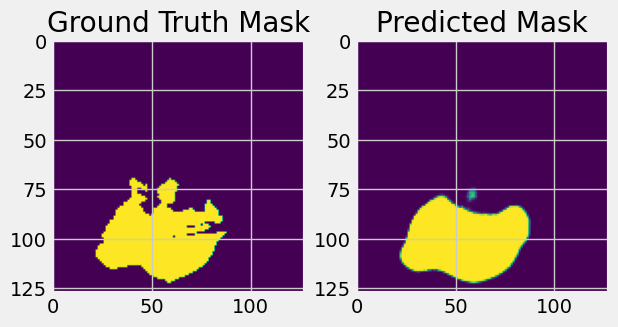

--------------------------


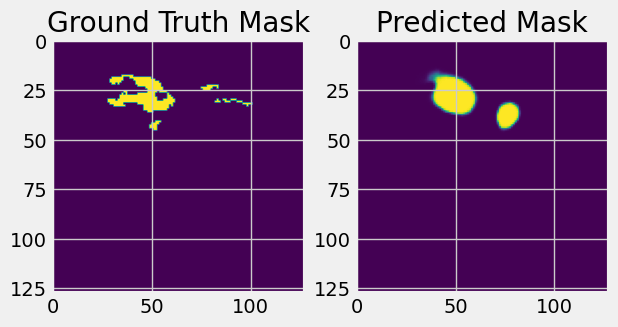

--------------------------


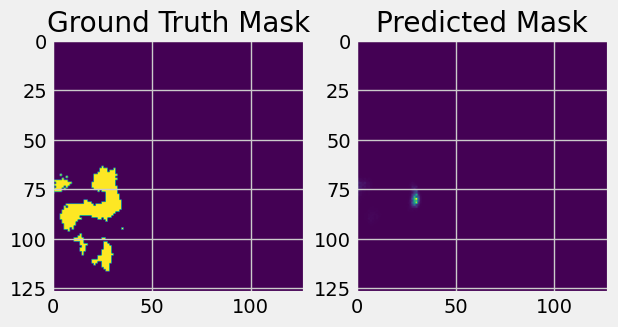

--------------------------


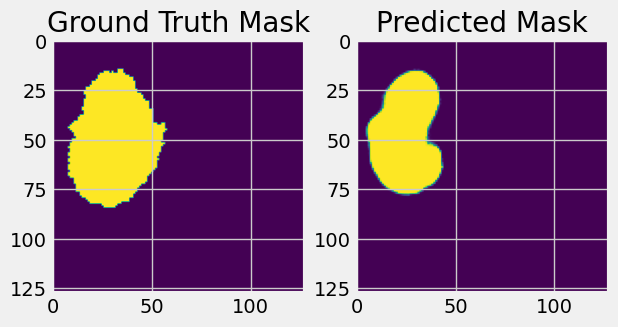

--------------------------


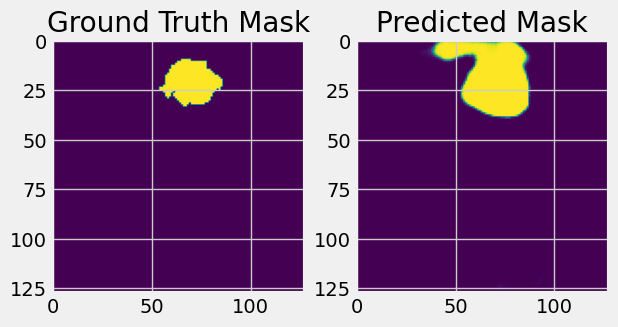

--------------------------


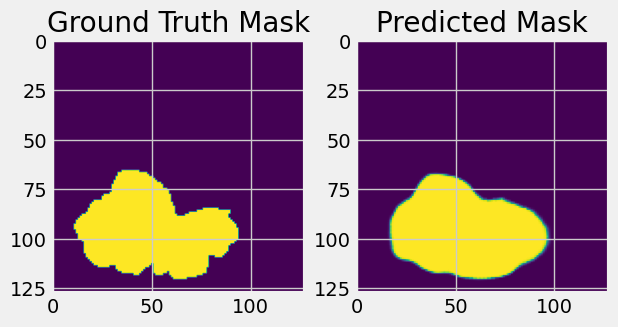

--------------------------


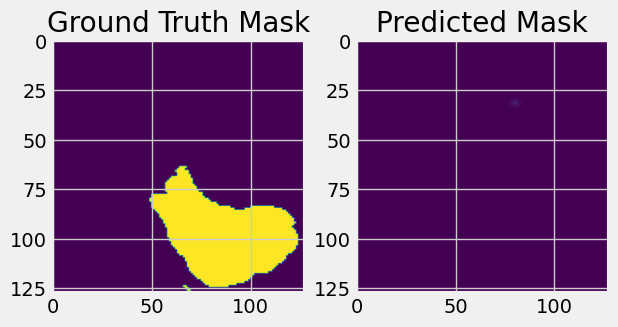

--------------------------


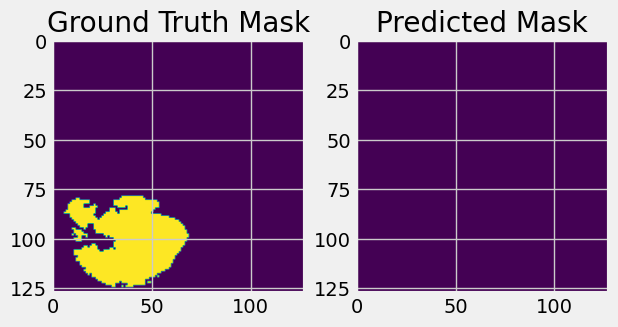

--------------------------


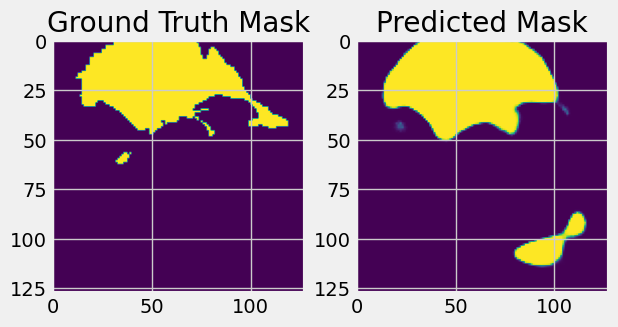

--------------------------


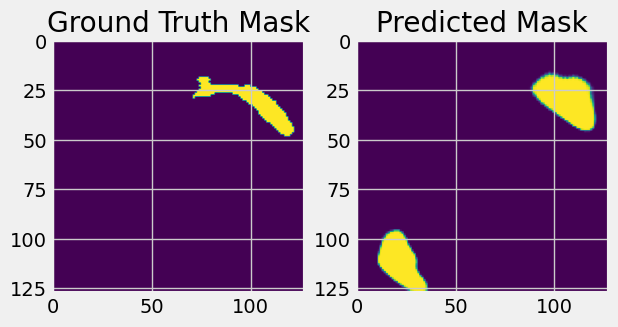

--------------------------


In [42]:
display_predictions(1,45)

for i in range (len(preds)):
    display_predictions(i,45)

## Results model trained without augmentation 

it seems that our model is more likely to give false positives (predicts there is a tumor when there is not a tumor) than false negatives (predicting no tumor when there is a tumor). 

In terms of this project, I think it is better to give false positive than false negatives. 

## Model trained with augmentation

There seem to be more false positives which is not a good thing